# Соревнования про медицину

https://inclass.kaggle.com/c/competition-2-yandex-shad-spring-2017

В файлах X.train и y.train задана обучающая выборка, X.test - выборка, для которой необходимо сделать предсказание.
Признаки

Для каждого пациента задано описание в виде 1330 признаков:

    Столбцы с V2 по V331 соответствуют различным медицинским показателям.
    Столбцы с V332 по V1331 соответствуют генетическими данными пациента.

Обратите внимание, что в случае неизвестного значения указано NaN.
Типы признаков

В файле MetaData содержится подробное описание типов каждого столбца признаков:

    Numeric - числовые признаки;
    Category - порядок значений нам не важен;
    Ordered Category - порядок значений важен;
    Генетические данные - их значения соответствуют частоте конкретного аллеля.

## Возникшие вопросы
* Чем же всё-таки второй метод удаления NaNов лучше?
* Можно ли что-нибудь выгадать, округлив значения типа 0.80000000000002 ?
* SVC зависает на полных данных. В чём причина?
* Порядок колонок реально влияет на результат обучения! Нету ли нигде ошибки?


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For sklearn 0.18
import sklearn.model_selection as skcv
#import sklearn.cross_validation as skcv
import sklearn as sk
import sklearn.ensemble as sken
import sklearn.preprocessing as skpp
import sklearn.metrics as skm

In [4]:
MetaData = pd.read_csv('cont_02/MetaData.csv')
MetaData.columns = ["var","type","cat"]

X_train = pd.read_csv('cont_02/X.train.csv')
X_test = pd.read_csv('cont_02/X.test.csv')
Y_train = pd.read_csv('cont_02/y.train.csv')

In [5]:
print('X_train.shape=', X_train.shape)

X_train.shape= (4099, 1330)


1099


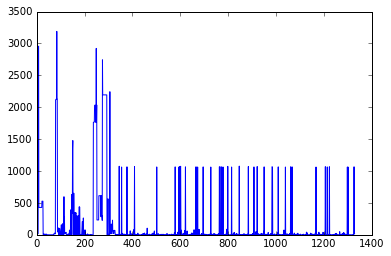

In [6]:
%matplotlib inline
numnulls = np.zeros((len(X_train.columns),))
for i,c in enumerate(X_train.columns):
    nulls = pd.isnull(X_train[c]).values
    numnulls[i] = len(nulls[nulls == True])
print(numnulls[numnulls < 30].size)
plt.plot(numnulls)

In [7]:
columns_ocat = MetaData[MetaData.loc[:,"cat"] == "Ordered Category"]["var"].values
columns_num = MetaData[MetaData.loc[:,"cat"] == "Numeric"]["var"].values
columns_cat = MetaData[MetaData.loc[:,"cat"] == "Category"]["var"].values
columns_nanfree = X_train.columns[numnulls == 0]
columns_all = X_train.columns
#for c in columns_ocat:
#    print(set(X_train[c]))
columns_nanfree

Index(['V3', 'V4', 'V29', 'V30', 'V31', 'V33', 'V36', 'V37', 'V38', 'V39',
       ...
       'V1309', 'V1311', 'V1314', 'V1315', 'V1317', 'V1318', 'V1320', 'V1322',
       'V1324', 'V1327'],
      dtype='object', length=374)

## Базовое решение

In [8]:
imputer = skpp.Imputer(strategy='most_frequent')
X_train_mean = imputer.fit_transform(X_train.values)
X_test_mean = imputer.transform(X_test.values)

In [9]:
clf = sken.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
print(clf)
np.mean(skcv.cross_val_score(clf, X_train_mean, Y_train.label.values, scoring='roc_auc', cv=5))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)


0.81565107584450658

## Идеи Алексея

Забегая вперед, получается, что заменять NaNы на мин/макс элементы немного перспективнее. Почему - непонятно.

### Заменить NaN на нули, снабдить колонки копиями с isNaN-признаком (0/1)

In [10]:
def denan1(X):
    XA = X.copy()
    XB = X.copy()
    nans = pd.isnull(XB)
    XB[nans] = 1
    XB[~nans] = 0
    #XB.columns = [x + 'N' for x in X2.columns]
    XA[nans] = 0
    return pd.concat([XA, XB], axis=1)

In [11]:
X_train_nan1 = denan1(X_train)

In [12]:
clf = sken.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
print(clf)
score1 = skcv.cross_val_score(clf, X_train_nan1, Y_train.label.values, scoring='roc_auc', cv=5)
print(score1)
np.mean(score1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)
[ 0.80781684  0.84461298  0.78029294  0.85674003  0.83965497]


0.82582355230844562

### Заменить NaN на нули, снабдить колонки копиями с isNaN-признаком (min-1/max+1)

In [13]:
def denan2(X):
    XA = X.copy()
    XB = X.copy()
    for c in XB.columns:
        col = XB[c]
        cmin,cmax = col.min(), col.max()
        nans = pd.isnull(col)
        XB.loc[nans,c] = cmin
        #XA.loc[nans,c] = cmin
        XB.loc[~nans,c] = cmax
    #XB.columns = [c+"N" for c in X.columns]
    imputer = skpp.Imputer(strategy='mean')
    XA[:] = imputer.fit_transform(XA.values)
    return pd.concat([XA,XB],axis=1)
        
def test_denan2():
    df = pd.DataFrame(np.arange(10).reshape(-1, 2), columns=['A', 'B'])
    c = df['A']
    c[0] = 4.0
    c[c>4] = None
    return denan2(df)

test_denan2()

,A,B,A,B
0,4.000000,1.0,4.0,9
1,2.000000,3.0,4.0,9
2,4.000000,5.0,4.0,9
3,3.333333,7.0,2.0,9
4,3.333333,9.0,2.0,9


In [14]:
X_train_nan2 = denan2(X_train)

In [15]:
clf = sken.RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, random_state=1)
print(clf)
score2all = np.mean(skcv.cross_val_score(clf, X_train_nan2[columns_all], Y_train.label.values, scoring='roc_auc', cv=5))
score2num = np.mean(skcv.cross_val_score(clf, X_train_nan2[columns_num], Y_train.label.values, scoring='roc_auc', cv=5))
score2cat = np.mean(skcv.cross_val_score(clf, X_train_nan2[columns_cat], Y_train.label.values, scoring='roc_auc', cv=5))
#score2ocat = np.mean(skcv.cross_val_score(clf, X_train_nan2[columns_ocat], Y_train.label.values, scoring='roc_auc', cv=5))
print('all =', score2all, 'num =', score2num, 'cat =', score2cat)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)
all = 0.834276590238 num = 0.822708000888 cat = 0.837794633849


In [16]:
clf = sken.AdaBoostClassifier(base_estimator=
                              sken.RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, random_state=1))
print(clf)
np.mean(skcv.cross_val_score(clf, X_train_nan2[columns_all], Y_train.label.values, scoring='roc_auc', cv=5))
#score2num = np.mean(skcv.cross_val_score(clf, X_train_nan2[columns_num], Y_train.label.values, scoring='roc_auc', cv=5))
#score2cat = np.mean(skcv.cross_val_score(clf, X_train_nan2[columns_cat], Y_train.label.values, scoring='roc_auc', cv=5))
#score2ocat = np.mean(skcv.cross_val_score(clf, X_train_nan2[columns_ocat], Y_train.label.values, scoring='roc_auc', cv=5))
#print('all =', score2all, 'num =', score2num, 'cat =', score2cat)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None)


0.82885794912497612

In [17]:
set(X_train['V1327'].values)

{0.0, 0.5, 1.0}

## Обучение SVM

In [19]:
clf = sk.svm.LinearSVR()
print(clf)
skcv.cross_val_score(clf, X_train_nan2[columns_all], Y_train.label.values, scoring='roc_auc', cv=5)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)


array([ 0.81059071,  0.8117899 ,  0.7588017 ,  0.74095469,  0.81183575])

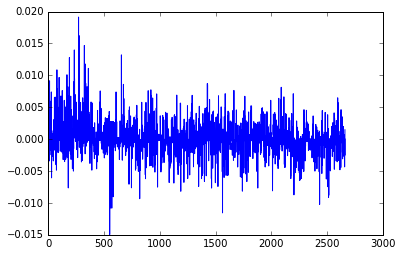

In [25]:
plt.plot(clf.coef_)


## Попытка создать свой комбинированный предсказатель

In [194]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [195]:
class MyClassifier(BaseEstimator, ClassifierMixin):  
    def __init__(self):
        self.clf =  sk.svm.SVC()

    def fit(self, X, y=None):
        return self.clf.fit(X,y)

    def predict(self, X, y=None):
        return self.clf.predict(X,y)
    
    def predict_proba(self, X, y=None):
        return self.clf.predict_proba(X,y)

    def score(self, X, y=None):
        return self.clf.score(X,y) 
    
    def decision_function(self,X):
        return self.clf.decision_function(X)



clf = MyClassifier()
skcv.cross_val_score(clf, X_train_nan2[columns_num], Y_train.label.values, scoring='roc_auc', cv=5)

array([ 0.74629972,  0.74540227,  0.68335939,  0.77069789,  0.7577152 ])